In [1]:
%pylab inline --no-import-all
import math
import numpy as np
import emcee
import scipy.optimize as op

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [39]:
#dataset
np.random.seed(1239)
x = 10 * np.sort(np.random.rand(10))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))
y2D = y.reshape(-1,1)
x2D=x.reshape(-1,1)

x_pred = np.linspace(0, 10)
x_pred2D = np.linspace(0, 10).reshape(-1,1)


# scikit learn

In [40]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

** Make Kernel and initalize GP object. GaussianProcessRegressor can take in noise parameter alpha and option to set mean to mean of the training data set (normalize_y = True). Kernel can take in bounds on hyperparameters  **

In [41]:
kernel = 1.**2*Matern(length_scale=1, nu=1.5)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
print gp

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=1.5),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)


** Optimize hyperparameters. Uses scipy.optimize to maximize log likelihood, but can change optimizer. Option to run optimization multiple times to avoid lovcal max/min (n_restart_optimizer). Hyperparameters can be fixed by passing None in for optimizer**

In [42]:
gp.fit(x2D, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=1.5),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

** Get mean and eith standard deviation (return_std=True) or covariance (return_cov=True) of conditional predictive distribution. **

In [43]:
y_pred, sigma = gp.predict(x_pred2D, return_std=True)

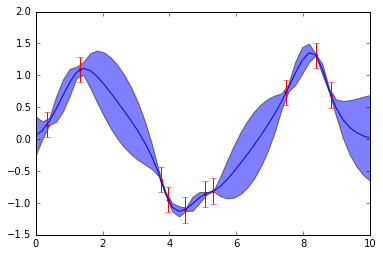

In [44]:
plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, y_pred-sigma, y_pred+sigma, facecolor='b', alpha=0.5)

** Draw samples from conditional predictive distribution. If called after gp.fit(x,y) will return samples from posterior, if called before will return samples from prior. **

(-3, 3)

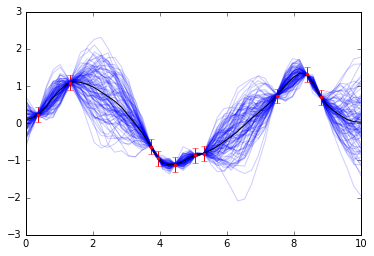

In [45]:
plt.figure()
samps = gp.sample_y(x_pred2D,100)
avg=[]
for s in range(100):
    samp = samps[:,s]
    avg.append(samp)
    plt.plot(x_pred, samp, c='b', alpha=0.2)
plt.plot(x_pred, np.mean(avg, axis=0),c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.ylim([-3,3])

** to use external MCMC, use built in log_marginal_likelihood(params) to return log likelihood **

In [49]:
def lnprob(p):
    # Trivial improper prior: uniform in the log.
    if np.any((-5 > p) + (p > 5)):
        return -np.inf
    lnprior = 0.0
    gp.kernel_.theta=p
    return lnprior + gp.log_marginal_likelihood(p)

# Set up the sampler.
nwalkers, ndim = 36, len(gp.kernel_.theta)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = [gp.kernel_.theta + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 500)

print("Running production chain")
_, _, _ = sampler.run_mcmc(p0, 1000)


Running burn-in
Running production chain


(-3, 3)

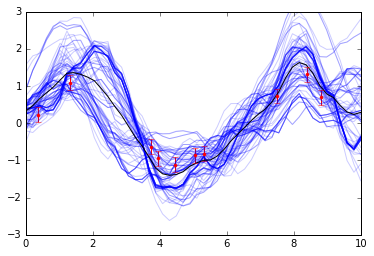

In [50]:
plt.figure()
samples = sampler.flatchain
avg=[]
for s in samples[:100]:
    gp.kernel_.theta=s
    # Plot a single sample.
    samp=gp.sample_y(x_pred2D)
    avg.append(samp)
    plt.plot(x_pred, samp, c='b', alpha=0.2)
plt.plot(x_pred, np.mean(avg, axis=0),c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.ylim([-3,3])

(-3, 3)

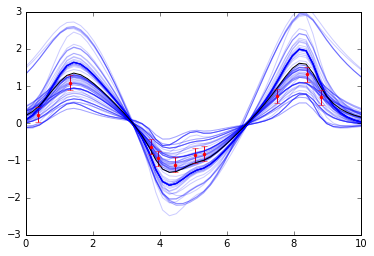

In [51]:
plt.figure()
samples = sampler.flatchain
avg=[]
for s in samples[:100]:
    gp.kernel_.theta=s
    # Plot mean of signal sample.
    samp=gp.predict(x_pred2D)
    avg.append(samp)
    plt.plot(x_pred, samp, c='b', alpha=0.2)
plt.plot(x_pred, np.mean(avg, axis=0),c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.ylim([-3,3])

** kernel_ is current state, kernel is intial state. theta returns log(hyperparameters). get_params() returns dictionary of hyperparameters. bounds returns set bounds on the hyperparameters (default [10^-5, 10^5]) ** 

In [52]:
print "initial set params: ", gp.kernel.get_params()
print
print "current params - returns log(hyperparameters):", gp.kernel_.get_params()
print
print "current hyperparameters params: ", np.exp(gp.kernel_.theta), "log(hyperparams)", gp.kernel_.theta
print
gp.kernel_.theta = [2,3]
print "new hyperparameters params:", np.exp(gp.kernel_.theta), "log(hyperparams)", gp.kernel_.theta
print
print "new params:", gp.kernel_.get_params()
print
print "bounds:", np.exp(gp.kernel.bounds)

initial set params:  {'k2__nu': 1.5, 'k1__constant_value': 1.0, 'k2__length_scale': 1, 'k2': Matern(length_scale=1, nu=1.5), 'k1': 1**2, 'k2__length_scale_bounds': (1e-05, 100000.0), 'k1__constant_value_bounds': (1e-05, 100000.0)}

current params - returns log(hyperparameters): {'k2__nu': 1.5, 'k1__constant_value': 0.62929627558357282, 'k2__length_scale': 1.5524142033738511, 'k2': Matern(length_scale=1.55, nu=1.5), 'k1': 0.793**2, 'k2__length_scale_bounds': (1e-05, 100000.0), 'k1__constant_value_bounds': (1e-05, 100000.0)}

current hyperparameters params:  [ 0.62929628  1.5524142 ] log(hyperparams) [-0.46315311  0.43981127]

new hyperparameters params: [  7.3890561   20.08553692] log(hyperparams) [ 2.  3.]

new params: {'k2__nu': 1.5, 'k1__constant_value': 7.3890560989306504, 'k2__length_scale': 20.085536923187668, 'k2': Matern(length_scale=20.1, nu=1.5), 'k1': 2.72**2, 'k2__length_scale_bounds': (1e-05, 100000.0), 'k1__constant_value_bounds': (1e-05, 100000.0)}

bounds: [[  1.00000000

** Others **
* can combine kernels
* can't create own kernel (I don't think)



# george

In [53]:
import george
from george.kernels import Matern32Kernel


** no built in optimization for hyperparameters - use built in lnlikelihood to minimize negative log likelihood through scipy.optimize. Likelihood is Gaussian **

In [54]:
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

** Create kernel, initalize GP object with kernel. george.GP can also take in a mean function, and can change solver for internal linear algebra calculations ** 

In [55]:
kernel = 2.*Matern32Kernel(3.)
gp = george.GP(kernel)


** calculates the covariance matrix for a set of points **

In [56]:
gp.compute(x, yerr)

** optimize hyperparameters using scipy.optimize.minimize. Get and set hyperparameters with gp.kernel[]. returns log(hyperpameters) **

In [57]:
p0 = gp.kernel[:]
results = op.minimize(nll, p0, jac=grad_nll)
gp.kernel[:] = results.x
print "hyperparameters, log(hyperparameters): ", np.exp(gp.kernel[:]), gp.kernel[:]

hyperparameters, log(hyperparameters):  [ 0.62285489  1.91378418] [-0.4734417   0.64908253]


** recompute covariance matrix with best fit hyperparameters.
Get mean and covariance of conditional predicitve distribution **

In [58]:
gp.compute(x, yerr)
y_pred, sigma = gp.predict(y, x_pred)

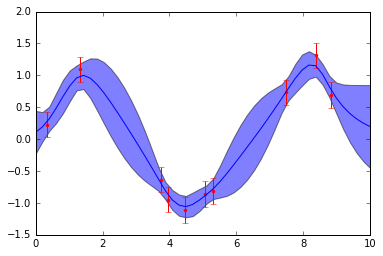

In [59]:
plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, y_pred-np.sqrt(np.diag(sigma)), y_pred+np.sqrt(np.diag(sigma)), facecolor='b', alpha=0.5)

** Draw samples from conditional predictive distribution **

<Container object of 3 artists>

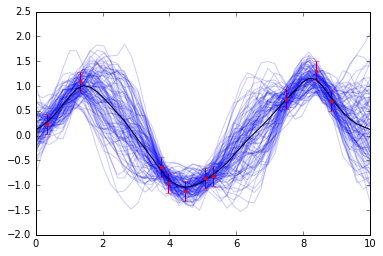

In [60]:
plt.figure()
samples = gp.sample_conditional(y, x_pred, size=100)
avg = []
for s in range(100):
    samp = samples[s,:]
    avg.append(samp)
    plt.plot(x_pred, samp, c='b', alpha=0.2)
plt.plot(x_pred, np.mean(avg, axis=0), c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')

** use flat prior and built in lnlikelihood function to run MCMC **

In [61]:
def lnprob(p):
    #uniform prior in log on hyperparameters
    if np.any((-10 > p) + (p > 10)):
        return -np.inf
    lnprior = 0.0
    #returns log(hyperparameters)
    gp.kernel[:] = p
    #lnlikelihood returns log likelihood of a set of observations
    return lnprior + gp.lnlikelihood(y, quiet=True)



In [62]:
# Set up the sampler.
nwalkers, ndim = 36, len(gp.kernel[:])
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = [gp.kernel[:] + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 2000)

print("Running production chain")
_,_,_ = sampler.run_mcmc(p0, 2000)

Running burn-in
Running production chain


(50,) (50,)


<Container object of 3 artists>

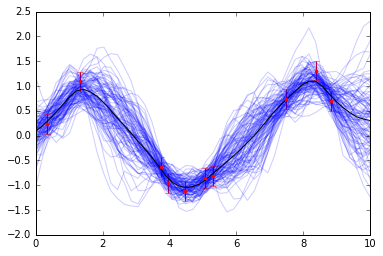

In [63]:
plt.figure()
samples = sampler.flatchain
avg = []
for s in samples[:100]:
    gp.kernel[:] = s
    # Plot a single sample.
    samp = gp.sample_conditional(y, x_pred)
    avg.append(samp)
    plt.plot(x_pred, samp, c='b', alpha=0.2)
print samp.shape, np.mean(avg, axis=0).shape
plt.plot(x_pred, np.mean(avg, axis=0), c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')

(50,) (50,)


<Container object of 3 artists>

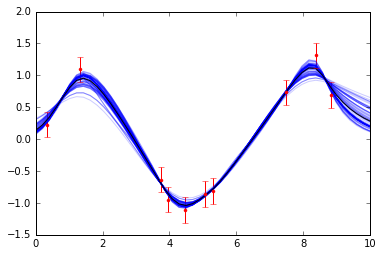

In [64]:
plt.figure()
samples = sampler.flatchain
avg = []
for s in samples[:100]:
    gp.kernel[:] = s
    # Plot mean of a sample.
    samp, sig= gp.predict(y, x_pred)
    avg.append(samp)
    plt.plot(x_pred, samp, c='b', alpha=0.2)
print samp.shape, np.mean(avg, axis=0).shape
plt.plot(x_pred, np.mean(avg, axis=0), c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')

** Other **
* can build own kernel
* can combine kernels
* can have a mean, but can't update mean parameters so its useless for our case


## GPflow


In [65]:
import GPflow

** build kernel, initalize model. Can add a predefined mean function into the GPR object. Likelihood is Gaussian **

In [66]:
#variance is amplitude 
kernel = GPflow.kernels.Matern32(1, variance=1, lengthscales=1.2) 
m = GPflow.gpr.GPR(x2D, y2D, kern=kernel)
print "before optimizing"
m


before optimizing


Name,values,prior,constraint
model.kern.variance,[ 1.],None,+ve
model.kern.lengthscales,[ 1.2],None,+ve
model.likelihood.variance,[ 1.],None,+ve


** optimize using scipy.optimize.minimize to get hyperparameters **
** m.likelihood.variance is white noise parameter **

In [67]:
m.likelihood.variance = 0.01
m.optimize()
print "afer optimizing"
m

afer optimizing


Name,values,prior,constraint
model.kern.variance,[ 0.67109156],None,+ve
model.kern.lengthscales,[ 1.26053874],None,+ve
model.likelihood.variance,[ 1.00889806e-06],None,+ve


** mean and covariance of conditional predictive distribution. predict_y and predict_f will be the same if likelihood is gaussian. Otherwise, predict_f returns mean and variance of latent function (i.e. normal Gaussian of GP) and predict_y will return mean and variance of new data points (based on likelihood provided) **

In [68]:
y_pred, sigma = m.predict_f(x_pred2D)
y2, sig2 = m.predict_y(x_pred2D)

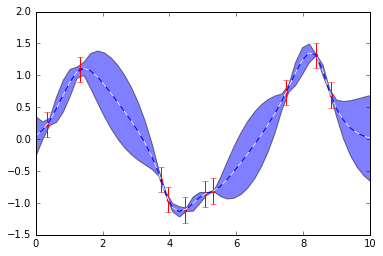

In [69]:
plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.plot(x_pred, y_pred, c='b')
plt.plot(x_pred, y2, c='w',ls='--')
plt.fill_between(x_pred, y_pred.squeeze()-np.sqrt(sigma.squeeze()), y_pred.squeeze()+np.sqrt(sigma.squeeze()), facecolor='b', alpha=0.5)

** can assign priors on hyperparameters, or fix hyperparameters **

In [70]:
m.kern.variance.prior = GPflow.priors.Gaussian(0, 1)
m.kern.lengthscales.prior = GPflow.priors.Gaussian(0, 1)
##can fix values if we know them (they say i.e. measurement error)
m.likelihood.variance = 0.1
m.likelihood.variance.fixed = True
m.optimize()
m

Name,values,prior,constraint
model.kern.variance,[ 0.60410822],"N([ 0.],[ 1.])",+ve
model.kern.lengthscales,[ 1.18863759],"N([ 0.],[ 1.])",+ve
model.likelihood.variance,[ 0.1],None,[FIXED]


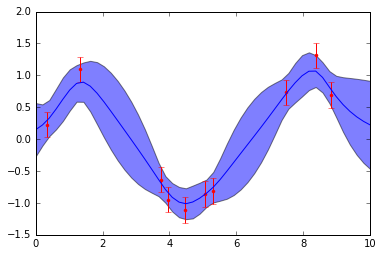

In [71]:
y_pred, sigma = m.predict_f(x_pred2D)

plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.plot(x_pred, y_pred, c='b')
plt.fill_between(x_pred, y_pred.squeeze()-np.sqrt(sigma.squeeze()), y_pred.squeeze()+np.sqrt(sigma.squeeze()), facecolor='b', alpha=0.5)

** sample from predictive distribution **

<Container object of 3 artists>

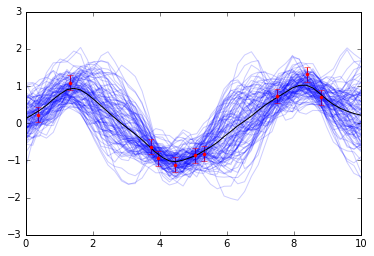

In [72]:
plt.figure()
samples = m.predict_f_samples(x_pred2D, 100)
avg = []
for s in range(100):
    samp = samples[s,:]
    avg.append(samp)
    plt.plot(x_pred, samp, c='b', alpha=0.2)
plt.plot(x_pred, np.mean(avg, axis=0), c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')

** for MCMC instead of regression, change class from GPR to GPMC. Need to specify likelihood and priors **

In [74]:
ll = GPflow.likelihoods.StudentT()
m = GPflow.gpmc.GPMC(x2D, y2D, kern = kernel, likelihood = ll)
m.kern.variance.prior = GPflow.priors.Gamma(1,1)
m.kern.lengthscales.prior = GPflow.priors.Gamma(1,1)

** sample runs Hamiltonian MC. Takes in epsilon (step size) and Lmax (max number of steps) **

In [75]:
trace = m.sample(1000, verbose=True, epsilon=0.03, Lmax=15)

Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  60.0 %
Iteration:  300 	 Acc Rate:  65.0 %
Iteration:  400 	 Acc Rate:  99.0 %
Iteration:  500 	 Acc Rate:  98.0 %
Iteration:  600 	 Acc Rate:  79.0 %
Iteration:  700 	 Acc Rate:  69.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  82.0 %
Iteration:  1000 	 Acc Rate:  86.0 %


** set hyperparameters of MC step with set_state(). predict_f_samples returns samples from the latent function. **

<Container object of 3 artists>

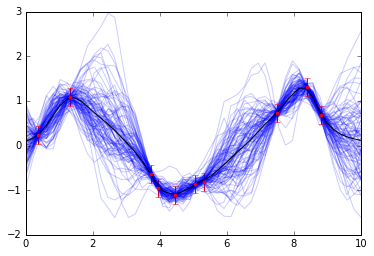

In [76]:
realizations = []
for sample in trace[-100:]:
    m.set_state(sample)
    realizations.append(m.predict_f_samples(x_pred2D, 1).squeeze())
realizations = np.vstack(realizations)

for r in realizations:
    plt.plot(x_pred, r, c='b', alpha=0.2)
plt.plot(x_pred, np.mean(realizations, axis=0), c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')

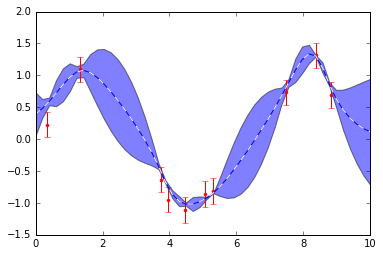

In [77]:
y_pred, sigma = m.predict_f(x_pred2D)
y2, sig2 = m.predict_y(x_pred2D)
plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.plot(x_pred, y_pred, c='b')
plt.plot(x_pred, y2, c='w',ls='--')
plt.fill_between(x_pred, y_pred.squeeze()-np.sqrt(sigma.squeeze()), y_pred.squeeze()+np.sqrt(sigma.squeeze()), facecolor='b', alpha=0.5)

**Other **
* can make own kernel
* can combine kernel

## PYMC3

In [78]:
import pymc3 as pm
import theano.tensor as tt
import theano

** Set up model and kernel with priors on hyperparameters. Set up zero mean and white noise. Mean must be a built-in function, same with priors  **

In [79]:
gp_fit = pm.Model()
with gp_fit:
    r = pm.Gamma('r', 1, 1)
    n = pm.Gamma('n', 1, 1)
    K = n * pm.gp.cov.Matern32(1, r)

with gp_fit:
    M = pm.gp.mean.Zero()
    #noise variable
    sig = pm.HalfCauchy('sigma', 2.5)



** calculate the marginal likelihood with mean function, covariance function, and noise **

In [80]:
with gp_fit:
    y_gp = pm.gp.GP('y_obs', mean_func=M, cov_func=K, sigma=sig, observed={'X':x2D, 'Y':y})

print y_gp

** optimize to get hyperparameters. default optimizer is BFGS - can change to another optimizer with fmin flag **

In [81]:
map_estimate = pm.find_MAP(model=gp_fit) 
print map_estimate

Optimization terminated successfully.
         Current function value: 12.619217
         Iterations: 10
         Function evaluations: 13
         Gradient evaluations: 13
{'r_log_': array(0.28206242569456863), 'sigma_log_': array(-1.8251558785837545), 'n_log_': array(-0.37674839100403423)}


** MCMC to optimize hyperparameters. Default is NUTS**

In [82]:
with gp_fit:
    trace = pm.sample(2000, n_init=20000)

100%|██████████| 2000/2000 [00:08<00:00, 241.78it/s]


** draw samples from the predictive distribution **

In [83]:
with gp_fit:
    gp_samples = pm.gp.sample_gp(trace[1000:], y_gp, x_pred2D, samples=50)

100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


<Container object of 3 artists>

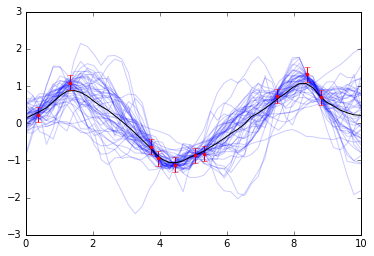

In [84]:
for s in gp_samples:
    plt.plot(x_pred, s, c='b', alpha=0.2)
plt.plot(x_pred, np.mean(gp_samples, axis=0), c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')

** Other **
* there is no **predict** function to get mean and variance of predictive distribution
* can't create own kernel, but has more build in kernels to choose from
* can combine kernels

## Celerite

In [85]:
import celerite

** same as george - no built in optimization, so use built in log likelihood and scipy minimize. Now use get_parameter_vector and set_parameter_vector **

In [86]:
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y)
    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25



** set up kernel and gp object. Can take in mean that is a float or created a function, as well as white noise that is float or created function. Can freeze mean and white noise parameters to not be fit **

In [87]:
kernel = celerite.terms.Matern32Term(1.,1.)
gp = celerite.GP(kernel=kernel)

** calculates the covariance matrix for a set of points **

In [88]:
gp.compute(x,yerr)

** optimize hyperparameters by minimizing loglikelihood with scipy **

In [89]:
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0)
gp.set_parameter_vector(results.x)
print "hyperparameters, log(hyperparameters) ", np.exp(gp.get_parameter_vector()), gp.get_parameter_vector()

hyperparameters, log(hyperparameters)  [ 0.7892138   1.38348165] [-0.23671802  0.32460326]


** recompute covariance matrix with new hyperparameters, get mean and variance of predictive distribution **

In [90]:
gp.compute(x, yerr)
y_pred, sigma = gp.predict(y, x_pred, return_var=True)

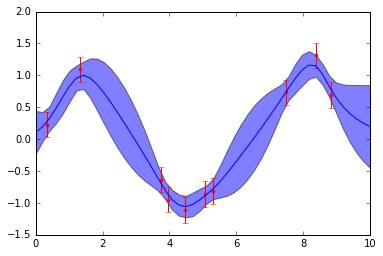

In [91]:
plt.errorbar(x, y, yerr, fmt='.',c='r')
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, y_pred-np.sqrt(sigma), y_pred+np.sqrt(sigma), facecolor='b', alpha=0.5)

** use emcee for MCMC. Sae setup as george **

In [92]:
def lnprob(p):
    #uniform prior in the log on hyperparameters
    if np.any((-10 > p) + (p > 10)):
        return -np.inf
    lnprior = 0.0
    gp.set_parameter_vector(p)
    if not np.isfinite(lnprior):
        return -np.inf
    #lnlikelihood returns log likelihood of a set of observations
    return lnprior + gp.log_likelihood(y)



In [93]:
# Set up the sampler.
nwalkers, ndim = 36, len(gp.get_parameter_vector())
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
p0 = [gp.get_parameter_vector() + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

print("Running burn-in")
p0, _, _ = sampler.run_mcmc(p0, 2000)

print("Running production chain")
_,_,_ = sampler.run_mcmc(p0, 2000)

Running burn-in
Running production chain


** mean and variance of predicitive distirbution for each MCMC sample **

(50,) (50,)


<Container object of 3 artists>

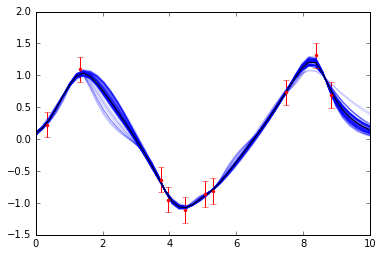

In [94]:
plt.figure()
samples = sampler.flatchain
avg = []
for s in samples[:100]:
    gp.set_parameter_vector(s)
    # Plot a single sample.
    samp = gp.predict(y, x_pred, return_cov=False)
    avg.append(samp)
    plt.plot(x_pred, samp, c='b', alpha=0.2)
print samp.shape, np.mean(avg, axis=0).shape
plt.plot(x_pred, np.mean(avg, axis=0), c='black')
plt.errorbar(x, y, yerr, fmt='.',c='r')

** Other **
* must make own kernel besides a small few that are built in, same for mean and white noise
* no sample function to draw from predictive distribution 

## Pystan also an option...

In [95]:
import pystan